## Importing libraries

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
import re

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

from scipy import interp
from itertools import cycle
import pickle

from time import time

# Import the Classification class from classification_code_class.py file 
from classification_code_class import Classification

## Load the datasets

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## Dimensions of both the datasets

In [4]:
print("Dimensions of the train set", train.shape )
print("Dimensions of the test set",test.shape )

Dimensions of the train set (19579, 3)
Dimensions of the test set (8392, 2)


## Store response to a variable and concat train and test

Store the response variable to a variable, say `y_true` and then drop it from the train set. This is done so that there won't be any dimension mismatch when we concatenate the train and test sets. 

In [ ]:
train_df = train.iloc[:,:-1]
y_true = train.iloc[:,-1]

df = pd.concat([train_df, test], axis = 0)

#%% CHECK FOR MISSING VALUES AND DROP THEM

df.isnull().sum()
# nomissing values in either of the datasets

## Check for Class Imbalance

In [16]:
print("Number of records in each class is\n"+str(train['author'].value_counts()))

# To check the percentage of each class 
print("\nPercentage distribution of each class is\n"+str(100*train['author'].value_counts()/len(train.author)))

Number of records in each class is
EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

Percentage distribution of each class is
EAP    40.349354
MWS    30.869809
HPL    28.780837
Name: author, dtype: float64


## Visualize class imbalance

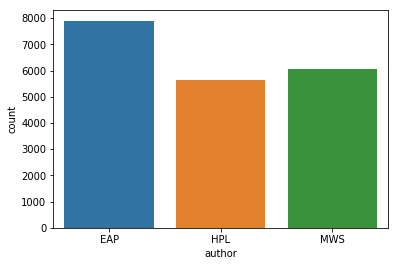

In [18]:
sns.countplot(train.author)

In [ ]:
#%% Shuffling

from sklearn.utils import shuffle
df = shuffle(df, random_state = 7)

#%% SEPARATE DATAFRAMES FOR EACH SENTIMENT

#%% Generate Word Cloud for each of the authors, if relevant. Check other kernels

# positivedf = df.loc[df["sentiment"] == 'positive']
# negativedf = df.loc[df["sentiment"] == 'negative']
# neutraldf = df.loc[df["sentiment"] == 'neutral']

## Stopwords and additions

Explore NLTK's built-in Stopwords and make additions of some required words

In [ ]:
builtinstopwords = stopwords.words('english')

#words needed for sentiment analysis
neededWords = ['mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
                'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
                'won', "won't", 'wouldn', "wouldn't",'aren', "aren't", 'couldn', "couldn't", 
                'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
                "haven't", 'isn', "isn't",'don', "don't", 'should', "should've", 'no', 'nor', 'not'] 

for word in neededWords:
    if word in builtinstopwords: 
        builtinstopwords.remove(word)

## Function to clean the text



In [ ]:
# TODO - check the difference in time when lemmatizer is instantiated inside the clean function vs outside
def clean(content):
    '''Code to clean text'''
    lm = WordNetLemmatizer()
    temptext = re.sub('[^a-zA-Z]', ' ', str(content))
    temptext = temptext.lower()
    tokens = nltk.word_tokenize(temptext)
    #tokens = [word for word in tokens if word not in set(builtinstopwords)] 
    cleanbody= [lm.lemmatize(word) for word in tokens if not word in set(builtinstopwords)]
    return (str(cleanbody)[1:-1])

df['cleaned']=df['text'].apply(lambda x : clean(x))
df.reset_index(drop=True,inplace=True)

In [ ]:
## Converting the cleaned text to vectors                          

In [ ]:
# FIT THE TFIDF VECTORIZER AND PICKLE THE VOCAB

#tfidf_obj = TfidfVectorizer(max_df=0.5,min_df=0.01,use_idf=True)
tfidf_obj = TfidfVectorizer(max_features = 5000)
X_train_tfidf = tfidf_obj.fit_transform(df.cleaned)

In [ ]:
#%%

# X_train_tfidf.shape

# feature_list = tfidf_obj.vocabulary_
# feature_list

#%%
#converting the array to a dataframe
X_train_test = pd.DataFrame(X_train_tfidf.todense(), columns = tfidf_obj.get_feature_names())

#y = df2['sentimentbinary']

X = X_train_test.iloc[:train.shape[0],:]

y = y_true

test_df = X_train_test.iloc[train.shape[0]:,:]
#%%

# TODO - Convert binaryReplacement to dictionary from epiphany code 
def binaryReplacement(variable):
    '''converting output categorical variable to numeric'''
    if variable == 'EAP':
        encoded_value = 0
    elif variable == 'HPL':
        encoded_value = 1
    else:
        encoded_value = 2
    return (encoded_value)

y = train['author'].apply(lambda x : binaryReplacement(x))

#%%
#del df, train, test, final_df, 
#%%

#analysis(predictionwithsampling(RandomOverSampler,RandomForestClassifier()))

#%% Instantiate a class object, create an instance called 'class_obj'
from classification_code_class import Classification

class_obj = Classification()
class_obj.analysis(X, y, RandomOverSampler, RandomForestClassifier())
class_obj.plot_roc()

#%%
param_grid = { 
   'n_estimators': [2, 5],
   'criterion' : ['gini', 'entropy']
}


best_parameters = class_obj.grid_search(param_grid) # returns best parameter grid 
print("Best Parameters are :", best_parameters)


#%% Re-train the classifier with new hyper-parameters

class_obj.analysis(X, y, RandomOverSampler, RandomForestClassifier())
#class_obj.pickle_classifier()
class_obj.plot_roc()



Make predictions on the test set. We are expected to predict the probabilities for each row for each of the 3 authors (use `predict_proba` method)

In [ ]:
y_pred_submission = class_obj._predict(test_df)

## Build the submission dataframe and export to csv

The final dataframe must have 4 columns - `id`, `EAP`, `HPL` and `MWS`.<br>
`id` must contain the same ids in the test.csv file. 

In [ ]:
sub_df = pd.DataFrame()
sub_df['id'] = test['id']
sub_df['EAP'] = y_pred_submission[:,0]
sub_df['HPL'] = y_pred_submission[:,1]
sub_df['MWS'] = y_pred_submission[:,2]

# sub_df.to_csv("submissions/v7.csv", index = False, header=True)